In [7]:
import torch
import torch.nn as nn
import torch.utils.data
import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from matplotlib import pyplot as plt


from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Dataset

In [3]:
df = pd.read_csv('train.csv')
df.head(3)

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0


In [4]:
# normalize
numpy_data = df.to_numpy(dtype=np.float32, copy=True)
data = numpy_data[:, :-1]
target = numpy_data[:, -1]

min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

In [5]:
train_data, val_data, train_target, val_target = train_test_split(data, target, stratify=target, test_size=0.2)

In [8]:
class Dataset_(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self._data = data
        self._target = np.expand_dims(target, -1)
        
    def __getitem__(self, idx):
        return torch.from_numpy(self._data[idx]), torch.from_numpy(self._target[idx]) 
    
    def __len__(self):
        return len(self._target)

### Models

#### 1. MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, in_feats=1524, dfs=False):
        super().__init__()
        self.dfs = dfs
        self.dfs_layer = nn.Linear(in_feats, in_feats)
        self.layer1 = nn.Linear(in_feats, 500)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(500, 100)
        self.out_layer = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        if self.dfs:
            w = self.dfs_layer.weight
            self.dfs_layer.weight = torch.nn.Parameter(w*torch.eye(w.size(0)))
            x = self.dfs_layer(x)
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        out = self.sigmoid(self.out_layer(x))
        return out

In [136]:
def train_step(model, train_loader, optimizer, criterion):
    model.train()
    mean_loss = 0
    total = 0
    
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        total += target.size(0)
    
    return mean_loss / total

def val_step(model, val_loader, optimizer, criterion):
    model.eval()
    
    with torch.no_grad():
        mean_loss = 0
        f1 = []
        total = 0
        for i, (data, target) in enumerate(val_loader):
            out = model(data)
            
            loss = criterion(out, target)
            mean_loss += loss.item()
            out = torch.squeeze(out).data.numpy()
            pred = np.where(out > 0.5, 1., 0.)
            f1.append(f1_score(pred, target.data.numpy()))
            total += data.size(0)
    
    return mean_loss / total, f1

def train_mlp(model, opt, crit, epochs_num, train_loader, val_loader):
    f1_scores = []
    for epoch in range(epochs_num):
        train_loss = train_step(model, train_loader, optimizer, criterion)
        val_loss, f1 = val_step(model, val_loader, optimizer, criterion)
        f1_scores.append(np.mean(f1))
        
#         print(f'Epoch [{epoch+1}/{epochs_num}] | Loss (train/val): {train_loss:.4f}/{val_loss:.4f}')
    return f1_scores

##### train with DFS layer


In [ ]:
# parameters
model_dfs = MLP(dfs=True)
train_dataset = Dataset_(train_data, train_target)
val_dataset = Dataset_(val_data, val_target)

optimizer = torch.optim.Adam(model_dfs.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()

full_train = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True)
full_val = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=32, 
                                           shuffle=True)

train_mlp(model_dfs, optimizer, criterion, 200, full_train, full_val)

In [65]:
# get feature-importance list
dfs_weights = model_dfs.dfs_layer.weight.data.numpy()
dfs_desc = np.argsort(np.max(np.abs(dfs_weights), axis=-1))[::-1]

#### 2. Random forest

In [ ]:
rf_base = RandomForestClassifier()

# grid search best params
params = {'n_estimators': [50, 100, 200], 
          'max_depth': [70,90,110], 
          'min_samples_leaf': [2, 3, 5]}

rf_grid_search = GridSearchCV(rf_base, refit=True, param_grid = params, 
                              scoring='f1', cv=2)
rf_grid_search.fit(data, target)

In [67]:
# get feature-importance list
rf_desc = np.argsort(rf_grid_search.best_estimator_.feature_importances_)[::-1]

#### 3. Gradient boosting classifier

In [ ]:
gb_base = GradientBoostingClassifier()

# grid search best params
params = {'n_estimators': [10, 20, 50], 
          'learning_rate': [0.01, 0.05, 0.1],
          'min_samples_leaf': [1, 2, 3]}

gb_grid_search = GridSearchCV(gb_base, refit=True, param_grid = params, 
                              scoring='f1', cv=2)
gb_grid_search.fit(data, target)

In [69]:
# get feature-importance list
gb_desc = np.argsort(gb_grid_search.best_estimator_.feature_importances_)[::-1]

### Feature selection comparison 

In [137]:
feat_importance = {'dfs': dfs_desc, 'gboost': gb_desc, 'random_forest': rf_desc}
num_feats = [100, 200, 400, 600, 800, 1000]
rf = RandomForestClassifier(**rf_grid_search.best_params_)
gb = GradientBoostingClassifier(**gb_grid_search.best_params_)
mlp = MLP()

rf_res = {k:[] for k,v in feat_importance.items()}
mlp_res, gb_res = deepcopy(rf_res), deepcopy(rf_res)
models_res = [[mlp, mlp_res], [gb, gb_res], [rf, rf_res]]

In [ ]:
for n in num_feats:
    for method, desc in feat_importance.items():
        reduced_train = train_data[:, desc[:n]]
        reduced_val = val_data[:, desc[:n]]
        for elem in models_res:
            model = elem[0]
        
            if isinstance(model, MLP):
                model = MLP(in_feats=n)
                train_dataset = Dataset_(reduced_train, train_target)
                val_dataset = Dataset_(reduced_val, val_target)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
                criterion = torch.nn.BCELoss()
                train = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=32, 
                                                    shuffle=True)
                val = torch.utils.data.DataLoader(dataset=val_dataset,
                                                  batch_size=32, 
                                                  shuffle=True)
                
                train_mlp(model, optimizer, criterion, 200, train, val)
                pred = model(torch.from_numpy(reduced_val)).data.numpy()
                pred = np.where(pred>0.5, 1, 0)
                score = f1_score(pred, val_target)
                elem[1][method].append([n, score])
                continue
            
            model.fit(reduced_train, train_target)
            pred = model.predict(reduced_val)
            score = f1_score(pred, val_target)
            elem[1][method].append([n, score])

In [141]:
def plot_results(result, model):
    for k, v in result.items():
        plt.plot(np.array(v)[:, 0], np.array(v)[:, 1], marker='o')
    plt.legend(list(rf_res.keys()))
    plt.title(model)
    plt.xlabel('num_features')
    plt.ylabel('f1-score')

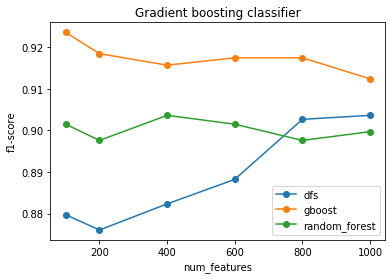

In [142]:
plot_results(gb_res, 'Gradient boosting classifier')

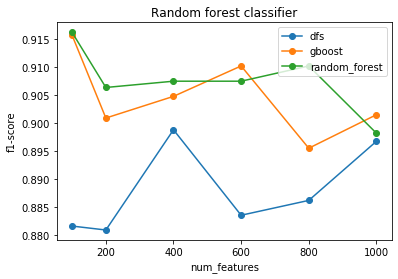

In [143]:
plot_results(rf_res, 'Random forest classifier')

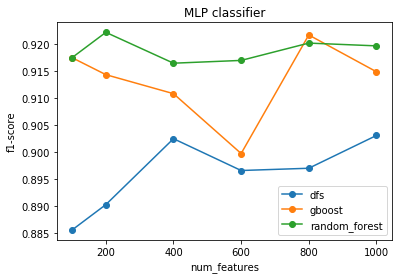

In [144]:
plot_results(mlp_res, 'MLP classifier')